In [1]:
from google.colab import drive
drive.mount('/content/MyDrive/')

Drive already mounted at /content/MyDrive/; to attempt to forcibly remount, call drive.mount("/content/MyDrive/", force_remount=True).


torch.Size([1, 4, 256, 512])
torch.Size([1, 2, 256, 512])
ENet(
  (encoder_net): ENetEncoder(
    (initial_block): InitialBlock(
      (convolution): Conv2d(1, 15, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (normalization): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (bottleneck1_0): Bottleneck(
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_down): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReL

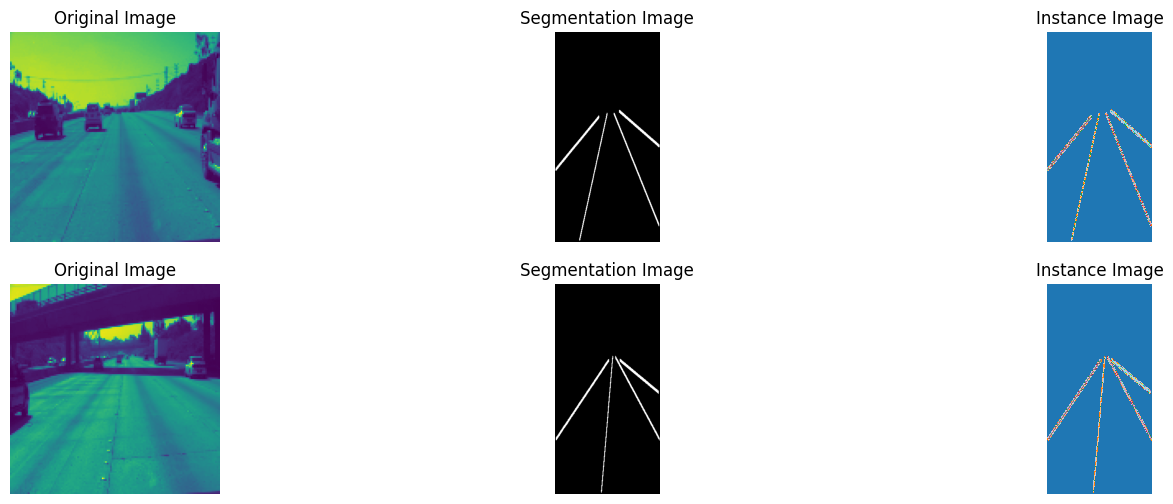

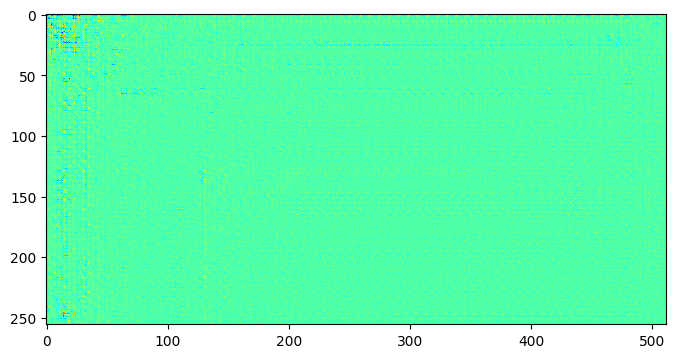

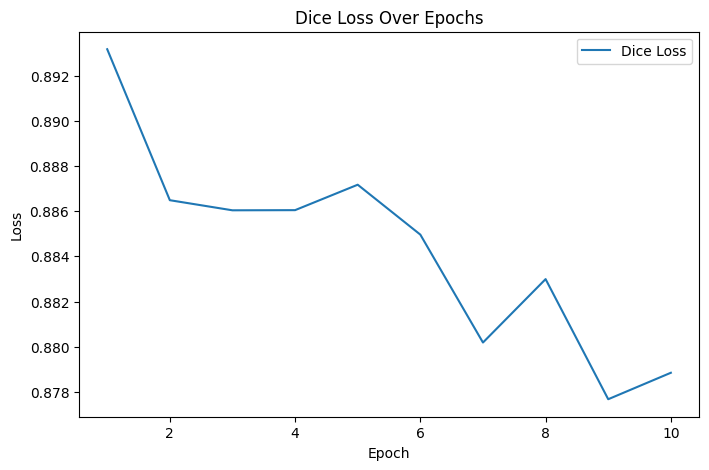

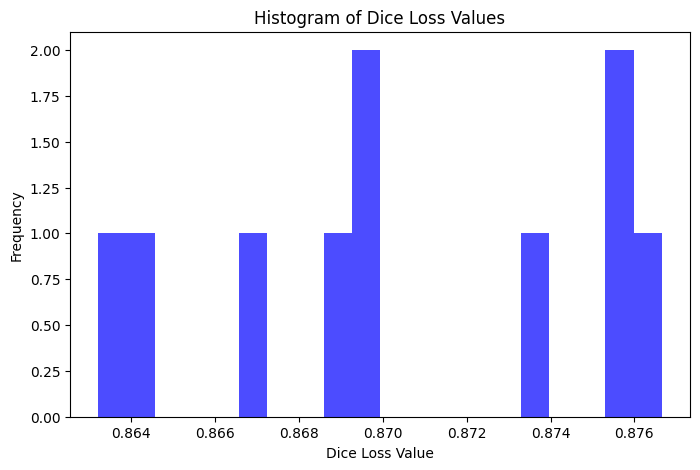

In [2]:
import json
import os
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.nn.modules.loss import _Loss
from torch.utils.data import DataLoader
import torch.optim as optim

import tqdm
import argparse
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
from torchsummary import summary
import random




## ---------------------------------------------------------------------------------------------------

class LaneDataset(Dataset):
    def __init__(self, json_path, train, size, image_folder):
        self._json_path = json_path
        self._mode = "train" if train else "eval"
        self._image_size = size
        self._image_folder = image_folder
        self._data = []
        self._process_labels()

    def __getitem__(self, idx):
        # Get lane data and image for this index
        lanes_coords, image = self._data[idx]

        # Resize the image
        h, w, c = image.shape
        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_LINEAR)

        # Convert to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Resize again to (128, 128) for final processing
        image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_LINEAR)

        # Add channel dimension and convert to PyTorch tensor
        image = torch.from_numpy(image).float().unsqueeze(0)  # Add channel dimension (C=1)

        # Generate segmentation and instance images
        segmentation_image = self._draw_lanes(h, w, lanes_coords, "segmentation")
        instance_image = self._draw_lanes(h, w, lanes_coords, "instance")

        # Convert segmentation and instance images to tensors
        segmentation_image = torch.from_numpy(segmentation_image.copy()).to(torch.int64)
        instance_image = torch.from_numpy(instance_image.copy()).unsqueeze(0)  # Add channel dimension

        return image, segmentation_image, instance_image

    def __len__(self):
        return len(self._data)

    def _draw_lanes(self, h, w, lanes, image_type):
        image = np.zeros((h, w), dtype=np.uint8)

        for i, lane in enumerate(lanes):
            color = 1 if image_type == "segmentation" else i + 1
            cv2.polylines(image, [lane], False, color, 10)

        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_NEAREST)
        return image

    def _process_labels(self):
      with open(self._json_path, "r") as file:
          for line in file:  # Read JSON file line by line
              try:
                  # Parse each line of JSON into a dictionary
                  entry = json.loads(line.strip())
                  if not isinstance(entry, dict):
                      raise ValueError(f"Expected a dictionary but got {type(entry)}")

                  # Extract relevant data
                  h_samples = entry["h_samples"]
                  lanes = entry["lanes"]
                  image_file_name = entry["raw_file"]
                  # single_raw_jpeg = raw_jpegs[line]

                  # Load the image
                  image_path = os.path.join(self._image_folder, image_file_name)
                  image = cv2.imread(image_path, cv2.IMREAD_COLOR)

                  if image is None:
                      print(f"Image not found at {image_path}")
                      continue

                  # Process lanes
                  lanes_coords = []
                  for lane in lanes:
                      x = np.array([lane]).T
                      y = np.array([h_samples]).T
                      xy = np.hstack((x, y))
                      idx = np.where(xy[:, 0] > 0)  # Filter out invalid points
                      lane_coords = xy[idx]
                      lanes_coords.append(lane_coords)

                  # Append processed data (image, lanes coordinates)
                  self._data.append((lanes_coords, image))

              except json.JSONDecodeError as e:
                  print(f"Error decoding JSON line: {line.strip()} - {e}")
              except ValueError as e:
                  print(f"Invalid entry type: {line.strip()} - {e}")
              except Exception as e:
                  print(f"Unexpected error: {str(e)}")



## ---------------------------------------------------------------------------------------------------

# Default settings
DEFAULT_SIZE = (256, 512)

# Define paths for your dataset
JSON_FILE = r"/content/MyDrive/MyDrive/LAne/labelled_data/label_data.json"
IMAGE_FOLDER = r"/content/MyDrive/MyDrive/LAne/labelled_data"



# Define paths for your dataset
# JSON_FILE = "train_set/labelled_data/label_data.json"
# IMAGE_FOLDER = "train_set/labelled_data"

# Set up required arguments
size = DEFAULT_SIZE  # Or specify a custom size, e.g., (256, 512)
image_folder = IMAGE_FOLDER  # Replace with the actual path to your image folder



## ---------------------------------------------------------------------------------------------------
## Call LaneDataset
# Instantiate the dataset with the required arguments
dataset = LaneDataset(json_path=JSON_FILE, train=True, size=DEFAULT_SIZE, image_folder=IMAGE_FOLDER)

# dataset = LaneDataset(json_path="label_data.json", image_folder="path_to_images", size=(720, 1280))
image, segment, ins = dataset[0]
ins = ins.to(device=torch.device('cpu'))
ins = ins.cpu()
image = image.cpu()

# # Visualize a sample
ind1 = random.randint(0, 100)
ind2 = random.randint(100, 200)

image1, segmentation_image1, instance_image1 = dataset[0]
image2, segmentation_image2, instance_image2 = dataset[10]

plt.figure(figsize=(18, 6))

plt.subplot(2, 3, 1)
plt.imshow(image1.permute(1, 2, 0).numpy().astype(np.uint8))  # Convert CHW to HWC
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(segmentation_image1.numpy(), cmap="gray")
plt.title("Segmentation Image")
plt.axis("off")

plt.subplot(2, 3, 3)
plt.imshow(instance_image1.permute(1, 2, 0).numpy(), cmap="tab20")
plt.title("Instance Image")
plt.axis("off")

plt.subplot(2, 3, 4)
plt.imshow(image2.permute(1, 2, 0).numpy().astype(np.uint8))  # Convert CHW to HWC
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 3, 5)
plt.imshow(segmentation_image2.numpy(), cmap="gray")
plt.title("Segmentation Image")
plt.axis("off")

plt.subplot(2, 3, 6)
plt.imshow(instance_image2.permute(1, 2, 0).numpy(), cmap="tab20")
plt.title("Instance Image")
plt.axis("off")

#plt.show()

## ---------------------------------------------------------------------------------------------------
class InitialBlock(nn.Module):

    def __init__(self, in_channels, out_channels, bias=False, act_relu=True, use_gpu=True, **kwargs):
        super().__init__()

        device = 'cpu' if use_gpu else 'cpu'
        self.device = torch.device(device)
        activation = nn.ReLU if act_relu else nn.PReLU

        # Update the input channels for the Conv2d layer to 3 (for RGB images)
        self.convolution = nn.Conv2d(in_channels, out_channels-1, kernel_size=3,
                                     stride=2, padding=1, bias=bias, device=self.device)
        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)
        self.normalization = nn.BatchNorm2d(out_channels, device=self.device)
        self.activation = activation()


    def forward(self, input_data):
        conv_out = self.convolution(input_data).to(self.device)
        pooled_out = self.max_pool(input_data).to(self.device)
        concat = torch.cat([conv_out, pooled_out], dim=1)
        norm = self.normalization(concat)
        activated = self.activation(norm)
        return activated


## ---------------------------------------------------------------------------------------------------
## ENet Encoder
class ENetEncoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        device = 'cpu'
        self.device =  torch.device(device)

        self.initial_block = InitialBlock(1, 16, **kwargs)

        self.bottleneck1_0 = Bottleneck(16, 16, 64, downsampling=True, dropout=0.01, **kwargs)
        self.bottleneck1_1 = Bottleneck(64, 16, 64, **kwargs)
        self.bottleneck1_2 = Bottleneck(64, 16, 64, **kwargs)
        self.bottleneck1_3 = Bottleneck(64, 16, 64, **kwargs)
        self.bottleneck1_4 = Bottleneck(64, 16, 64, **kwargs)

        self.bottleneck2_0 = Bottleneck(64, 32, 128, downsampling=True, **kwargs)
        self.bottleneck2_1 = Bottleneck(128, 32, 128, **kwargs)
        self.bottleneck2_2 = Bottleneck(128, 32, 128, dilation=2, **kwargs)
        self.bottleneck2_3 = Bottleneck(128, 32, 128, asymmetric=True, **kwargs)
        self.bottleneck2_4 = Bottleneck(128, 32, 128, dilation=4, **kwargs)
        self.bottleneck2_5 = Bottleneck(128, 32, 128, **kwargs)
        self.bottleneck2_6 = Bottleneck(128, 32, 128, dilation=8, **kwargs)
        self.bottleneck2_7 = Bottleneck(128, 32, 128, asymmetric=True, **kwargs)
        self.bottleneck2_8 = Bottleneck(128, 32, 128, dilation=16, **kwargs)

        self.bottleneck3_1 = Bottleneck(128, 32, 128, **kwargs)
        self.bottleneck3_2 = Bottleneck(128, 32, 128, dilation=2, **kwargs)
        self.bottleneck3_3 = Bottleneck(128, 32, 128, asymmetric=True, **kwargs)
        self.bottleneck3_4 = Bottleneck(128, 32, 128, dilation=4, **kwargs)
        self.bottleneck3_5 = Bottleneck(128, 32, 128, **kwargs)
        self.bottleneck3_6 = Bottleneck(128, 32, 128, dilation=8, **kwargs)
        self.bottleneck3_7 = Bottleneck(128, 32, 128, asymmetric=True, **kwargs)
        self.bottleneck3_8 = Bottleneck(128, 32, 128, dilation=16, **kwargs)

    def forward(self, input_data):

        x = self.initial_block(input_data).to(self.device)

        x, max_indices1 = self.bottleneck1_0(x)
        x = self.bottleneck1_1(x)
        x = self.bottleneck1_2(x)
        x = self.bottleneck1_3(x)
        x = self.bottleneck1_4(x)

        x, max_indices2 = self.bottleneck2_0(x)
        x = self.bottleneck2_1(x)
        x = self.bottleneck2_2(x)
        x = self.bottleneck2_3(x)
        x = self.bottleneck2_4(x)
        x = self.bottleneck2_5(x)
        x = self.bottleneck2_6(x)
        x = self.bottleneck2_7(x)
        x = self.bottleneck2_8(x)

        x = self.bottleneck3_1(x)
        x = self.bottleneck3_2(x)
        x = self.bottleneck3_3(x)
        x = self.bottleneck3_4(x)
        x = self.bottleneck3_6(x)
        x = self.bottleneck3_7(x)
        x = self.bottleneck3_8(x)

        return x, max_indices1, max_indices2

## ---------------------------------------------------------------------------------------------------
## ENet Model Decoder
class ENetDecoder(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super().__init__()

        self.upsampling_bottleneck4_0 = UpsamplingBottleneck(128, 16, 64, **kwargs)
        self.bottleneck4_1 = Bottleneck(64, 16, 64, **kwargs)
        self.bottleneck4_2 = Bottleneck(64, 16, 64, **kwargs)

        self.upsampling_bottleneck5_0 = UpsamplingBottleneck(64, 4, 16, **kwargs)
        self.bottleneck5_1 = Bottleneck(16, 4, 16, **kwargs)

        self.transposed_conv = nn.ConvTranspose2d(16, num_classes, 2, 2, bias=False, device=torch.device('cpu'))

    def forward(self, input_data, max_indices1, max_indices2):
        x = self.upsampling_bottleneck4_0(input_data, max_indices2)
        x = self.bottleneck4_1(x)
        x = self.bottleneck4_2(x)

        x = self.upsampling_bottleneck5_0(x, max_indices1)
        x = self.bottleneck5_1(x)

        # Output
        x = self.transposed_conv(x)
        return x

## ---------------------------------------------------------------------------------------------------
## Bottleneck
class Bottleneck(nn.Module):
    def __init__(self, in_dim, inter_dim, out_dim, dilation=1, asymmetric=False,
                 downsampling=False, norm_layer=nn.BatchNorm2d, dropout_rate=0.1, **kwargs):
        super().__init__()
        self.downsampling = downsampling

        if downsampling:
            self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
            self.conv_down = nn.Sequential(
                nn.Conv2d(in_dim, out_dim, 1, bias=False, device=torch.device('cpu')),
                norm_layer(out_dim, device=torch.device('cpu'))
            )

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_dim, inter_dim, 1, bias=False, device=torch.device('cpu')),
            norm_layer(inter_dim, device=torch.device('cpu')),
            nn.PReLU(device=torch.device('cpu'))
        )

        if downsampling:
            self.conv2 = nn.Sequential(
                nn.Conv2d(inter_dim, inter_dim, 2, stride=2, bias=False, device=torch.device('cpu')),
                norm_layer(inter_dim, device=torch.device('cpu')),
                nn.PReLU(device=torch.device('cpu'))
            )
        else:
            if asymmetric:
                self.conv2 = nn.Sequential(
                    nn.Conv2d(inter_dim, inter_dim, (5, 1), padding=(2, 0), bias=False, device=torch.device('cpu')),
                    nn.Conv2d(inter_dim, inter_dim, (1, 5), padding=(0, 2), bias=False, device=torch.device('cpu')),
                    norm_layer(inter_dim, device=torch.device('cpu')),
                    nn.PReLU(device=torch.device('cpu'))
                )
            else:
                self.conv2 = nn.Sequential(
                    nn.Conv2d(inter_dim, inter_dim, 3, dilation=dilation, padding=dilation, bias=False, device=torch.device('cpu')),
                    norm_layer(inter_dim, device=torch.device('cpu')),
                    nn.PReLU(device=torch.device('cpu'))
                )

        self.conv3 = nn.Sequential(
            nn.Conv2d(inter_dim, out_dim, 1, bias=False, device=torch.device('cpu')),
            norm_layer(out_dim, device=torch.device('cpu')),
            nn.Dropout2d(dropout_rate)
        )

        self.activation = nn.PReLU(device=torch.device('cpu'))

    def forward(self, x):
        identity = x

        if self.downsampling:
            identity, max_indices = self.maxpool(identity)
            identity = self.conv_down(identity)

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.activation(out + identity)

        if self.downsampling:
            return out, max_indices
        else:
            return out

## ---------------------------------------------------------------------------------------------------
## Upsampling
class UpsamplingBottleneck(nn.Module):

    def __init__(self, in_ch, inter_ch, out_ch, norm_layer=nn.BatchNorm2d, drop_prob=0.1, **kwargs):
        super().__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 1, bias=False, device=torch.device('cpu')),
            norm_layer(out_ch, device=torch.device('cpu'))
        )
        self.upsampling_op = nn.MaxUnpool2d(2)

        self.block_operations = nn.Sequential(
            nn.Conv2d(in_ch, inter_ch, 1, bias=False, device=torch.device('cpu')),
            norm_layer(inter_ch, device=torch.device('cpu')),
            nn.PReLU(device=torch.device('cpu')),
            nn.ConvTranspose2d(inter_ch, inter_ch, 2, 2, bias=False,device=torch.device('cpu')),
            norm_layer(inter_ch, device=torch.device('cpu')),
            nn.PReLU(device=torch.device('cpu')),
            nn.Conv2d(inter_ch, out_ch, 1, bias=False, device=torch.device('cpu')),
            norm_layer(out_ch, device=torch.device('cpu')),
            nn.Dropout2d(drop_prob)
        )
        self.activation = nn.PReLU(device=torch.device('cpu'))

    def forward(self, input_x, max_indices):
        output_upsampled = self.convolution(input_x)
        output_upsampled = self.upsampling_op(output_upsampled, max_indices)

        output_extended = self.block_operations(input_x)
        output = self.activation(output_upsampled + output_extended)
        return output


## ---------------------------------------------------------------------------------------------------
## ENet Model implementation
class ENet(nn.Module):
    def __init__(self, a, b):
        super(ENet, self).__init__()

        self.encoder_net = ENetEncoder()
        self.decoder_logits = ENetDecoder(a)
        self.decoder_embeddings = ENetDecoder(b)

    def forward(self, input_data):
        x, max_indices1, max_indices2 = self.encoder_net(input_data)

        logits = self.decoder_logits(x, max_indices1, max_indices2)
        embeddings = self.decoder_embeddings(x, max_indices1, max_indices2)

        return embeddings, logits


# Create test data and train
test_input = torch.ones((1, 1, 256, 512), device=torch.device('cpu'))
enet = ENet(2, 4)
binary, instance = enet(test_input)
print(binary.shape)
print(instance.shape)

print(enet)

summary(enet, input_size=(1, 256, 256))  # Assuming input is 256x256 RGB image


# Visualize the output
fig, ax = plt.subplots(figsize=(8, 5))
ax.imshow(instance[0, 0, :, :].cpu().detach().numpy(), cmap="jet")
#plt.show()


## ---------------------------------------------------------------------------------------------------
## Dice Loss Function Implementation
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        """
        Compute the Dice Loss.

        Args:
            preds (Tensor): Predicted segmentation map (N, C, H, W)
            targets (Tensor): Ground truth segmentation map (N, H, W)

        Returns:
            Tensor: Dice loss value
        """
        # Ensure targets has the correct shape (N, H, W)
        if targets.dim() == 3:  # If targets has batch dimension
            targets = targets.squeeze(1)  # Remove channel dimension if necessary

        # Resize targets to match preds spatial dimensions
        targets_resized = F.interpolate(
            targets.unsqueeze(1).float(),  # Add channel dimension
            size=preds.shape[2:],          # Resize to (H, W) of preds
            mode="nearest"
        ).squeeze(1).long()  # Remove channel dimension and convert to long

        # Convert targets to one-hot encoding
        targets_one_hot = F.one_hot(targets_resized, num_classes=preds.shape[1])

        # Rearrange dimensions to match (N, C, H, W)
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()

        # Apply softmax to predictions
        preds = F.softmax(preds, dim=1)

        # Calculate intersection and union
        intersection = torch.sum(preds * targets_one_hot, dim=(2, 3))
        union = torch.sum(preds + targets_one_hot, dim=(2, 3))

        # Dice coefficient
        dice_coeff = (2 * intersection + self.smooth) / (union + self.smooth)

        # Mean Dice Loss
        dice_loss = 1 - dice_coeff.mean()

        return dice_loss



## ---------------------------------------------------------------------------------------------------
### Integration with Training Loop
# Initialize the model and loss function
enet = ENet(2, 4).to(torch.device('cpu'))  # Initialize ENet on CPU
criterion = DiceLoss()  # Initialize Dice loss function

# Forward pass through the model
s_pred, ins_pred = enet(image[None, ...].to(device=torch.device('cpu')))  # Add batch dimension to the input

# Resize the segment to match s_pred dimensions
segment_resized = F.interpolate(segment.unsqueeze(0).unsqueeze(0).float(),  # Add batch and channel dimensions
                                size=s_pred.shape[2:],  # Match spatial dimensions
                                mode="nearest").squeeze(0).to(torch.int64)  # Remove batch dimension after resizing

# Compute the Dice loss
loss = criterion




print(s_pred.shape)
print(ins_pred.shape)
ins_pred = ins_pred.cpu()


## -------------------------------------------------------------------------------------------------
### Visualization of Loss During Training
# Training settings
num_epochs = 10
learning_rate = 1e-3
optimizer = torch.optim.Adam(enet.parameters(), lr=learning_rate)

# Store loss values
loss_values = []

for epoch in range(num_epochs):
    enet.train()
    optimizer.zero_grad()

    # Forward pass
    s_pred, _ = enet(image[None, ...])
    loss = criterion(s_pred, segment[None, ...])

    # Backward pass
    loss.backward()
    optimizer.step()

    # Log and store loss
    loss_values.append(loss.item())
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")




# During training loop, after calculating predictions and loss
# dice_value = calculate_dice_coefficient(s_pred, segment)

# Store the Dice Coefficient for plotting
# dice_values.append(dice_value)
# print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Dice Coefficient: {dice_value:.4f}")

# Training loop
# for epoch in range(num_epochs):
#     enet.train()  # Set model to training mode
#     optimizer.zero_grad()  # Zero gradients

#     # Forward pass
#     s_pred, _ = enet(image[None, ...])  # Add batch dimension
#     loss = criterion(s_pred, segment[None, ...])  # Calculate loss

#     # Backward pass
#     loss.backward()
#     optimizer.step()

#     # Calculate Dice coefficient after the forward pass
#     dice_value = calculate_dice_coefficient(s_pred, segment)

#     # Append the Dice value to the list
#     dice_values.append(dice_value)

#     # Log loss and Dice coefficient
#     print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Dice Coefficient: {dice_value:.4f}")

# # After the training loop, you can plot the Dice coefficient
# plt.figure(figsize=(8, 5))
# plt.plot(range(1, num_epochs + 1), dice_values, label="Dice Coefficient")
# plt.xlabel("Epoch")
# plt.ylabel("Dice Coefficient")
# plt.title("Dice Coefficient Over Epochs")
# plt.legend()
# plt.show()



# Plot loss values
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), loss_values, label="Dice Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Dice Loss Over Epochs")
plt.legend()
plt.show()

dice_loss_values = []  # Store all Dice loss values from the training

for epoch in range(num_epochs):
    enet.train()
    optimizer.zero_grad()
    s_pred, _ = enet(image[None, ...])
    loss = criterion(s_pred, segment[None, ...])
    dice_loss_values.append(loss.item())  # Save loss for each batch or epoch
    loss.backward()
    optimizer.step()

# After training completes
plt.figure(figsize=(8, 5))
plt.hist(dice_loss_values, bins=20, color='b', alpha=0.7)
plt.xlabel("Dice Loss Value")
plt.ylabel("Frequency")
plt.title("Histogram of Dice Loss Values")
plt.show()


# dice_coeff_values = []  # To store Dice coefficients for each epoch

# for epoch in range(num_epochs):
#     enet.train()
#     optimizer.zero_grad()
#     s_pred, _ = enet(image[None, ...])
#     loss = criterion(s_pred, segment[None, ...])
#     loss.backward()
#     optimizer.step()
#     dice_coeff = calculate_dice_coefficient(s_pred, segment)  # Implement this function if needed
#     dice_coeff_values.append(dice_coeff)
#     print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# # Now plot the Dice coefficient curve
# plt.figure(figsize=(8, 5))
# plt.plot(range(1, num_epochs + 1), dice_coeff_values, label="Dice Coefficient")
# plt.xlabel("Epoch")
# plt.ylabel("Dice Coefficient")
# plt.title("Dice Coefficient Over Epochs")
# plt.legend()
# plt.show()

# val_loss_values = []  # Store validation loss

# for epoch in range(num_epochs):
#     enet.train()
#     optimizer.zero_grad()
#     s_pred, _ = enet(image[None, ...])
#     loss = criterion(s_pred, segment[None, ...])
#     loss.backward()
#     optimizer.step()

#     # Validate the model (this part should be done after each training epoch)
#     with torch.no_grad():
#         s_pred_val, _ = enet(validation_image[None, ...])  # validation_image is your validation set
#         val_loss = criterion(s_pred_val, validation_segment[None, ...])  # validation_segment is your ground truth
#         val_loss_values.append(val_loss.item())

# # Now plot the training vs validation loss
# plt.figure(figsize=(8, 5))
# plt.plot(range(1, num_epochs + 1), loss_values, label="Training Dice Loss")
# plt.plot(range(1, num_epochs + 1), val_loss_values, label="Validation Dice Loss", linestyle="--")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Training vs. Validation Dice Loss Over Epochs")
# plt.legend()
# plt.show()

# dice_loss_per_batch = []  # Store Dice loss values per batch

# for epoch in range(num_epochs):
#     enet.train()
#     optimizer.zero_grad()
#     batch_losses = []
#     for i in range(num_batches):  # If you have multiple batches in each epoch
#         s_pred, _ = enet(image_batch[None, ...])  # For each batch
#         loss = criterion(s_pred, segment_batch[None, ...])  # For each batch
#         batch_losses.append(loss.item())
#     dice_loss_per_batch.append(batch_losses)

# # After training completes
# plt.figure(figsize=(8, 5))
# plt.boxplot(dice_loss_per_batch, vert=False)
# plt.xlabel("Dice Loss")
# plt.title("Distribution of Dice Loss per Batch")
# plt.show()





